<a href="https://colab.research.google.com/github/Mindauskas/energy_consumption/blob/master/energy_consumption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
   %tensorflow_version 2.x
except Exception:
   pass

TensorFlow 2.x selected.


In [0]:
%matplotlib inline  

In [0]:
SETUP = True

In [4]:
if SETUP:
  !pip install -q -U toai
  !pip install -U kaggle

     |████████████████████████████████| 153kB 15.1MB/s 
     |████████████████████████████████| 81kB 11.0MB/s 
     |████████████████████████████████| 296kB 61.7MB/s 
     |████████████████████████████████| 122kB 62.8MB/s 
     |████████████████████████████████| 61kB 6.3MB/s 
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.6.3 which is incompatible.
ERROR: google-colab 1.0.0 has requirement requests~=2.21.0, but you'll have requests 2.22.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
Requirement already up-to-date: kaggle in /usr/local/lib/python3.6/dist-packages (1.5.6)


In [5]:
print(__import__("toai").__version__)
print(__import__("tensorflow").__version__)

0.2.1
2.0.0


In [6]:
from toai.imports import *
from toai.data import DataBundle, DataParams, DataContainer
import tensorflow as tf
from tensorflow import keras

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/toai/imports.py:70: UserWarning: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.
  warnings.warn(str(error))


In [0]:
DATA_DIR = Path("data/web_traffic")
DATA_DIR.mkdir(parents=True, exist_ok=True)

TEMP_DIR = Path("temp/web_traffic")
TEMP_DIR.mkdir(parents=True, exist_ok=True)

In [0]:
df = pd.read_csv('PJM_Load_hourly.csv')

In [9]:
df.shape

(32896, 2)

In [10]:
df.head(5)

,Datetime,PJM_Load_MW
0,1998-12-31 01:00:00,29309.0
1,1998-12-31 02:00:00,28236.0
2,1998-12-31 03:00:00,27692.0
3,1998-12-31 04:00:00,27596.0
4,1998-12-31 05:00:00,27888.0


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32896 entries, 0 to 32895
Data columns (total 2 columns):
Datetime       32896 non-null object
PJM_Load_MW    32896 non-null float64
dtypes: float64(1), object(1)
memory usage: 514.1+ KB


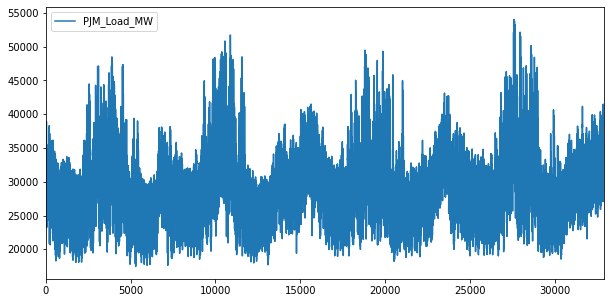

In [65]:
df.plot(figsize=(10,5))

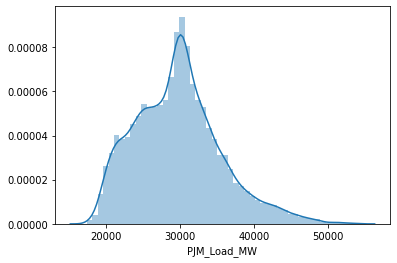

In [64]:
sns.distplot(df.PJM_Load_MW)

In [0]:
def split_timeseries_df(
    data: pd.DataFrame, test_size: float
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    train_data, test_data = train_test_split(data, test_size=test_size, shuffle=False)
    val_data, test_data = train_test_split(test_data, test_size=0.5, shuffle=False)
    return train_data, val_data, test_data

In [0]:
train_data, val_data, test_data = split_timeseries_df(df, 0.5)

In [16]:
[series.shape for series in (train_data, val_data, test_data)]

[(16448, 2), (8224, 2), (8224, 2)]

In [17]:
train_data.iloc[-1], val_data.iloc[0]

(Datetime       2000-11-16 12:00:00
 PJM_Load_MW                  32643
 Name: 16447, dtype: object, Datetime       2000-11-16 13:00:00
 PJM_Load_MW                  32018
 Name: 16448, dtype: object)

In [18]:
val_data.iloc[-1], test_data.iloc[0]

(Datetime       2001-12-09 06:00:00
 PJM_Load_MW                  22241
 Name: 24671, dtype: object, Datetime       2001-12-09 07:00:00
 PJM_Load_MW                  23152
 Name: 24672, dtype: object)

In [19]:
train_data.shape

(16448, 2)

In [0]:
def scale(series):
  return (series-np.mean(series))/np.std(series)

In [0]:
train_data, val_data, test_data = [
                                   scale(series.PJM_Load_MW.values).reshape(1,-1,1)
                                   for series in (train_data, val_data, test_data)
]

In [22]:
train_data.shape

(1, 16448, 1)

In [0]:
prediction_length = 24

In [0]:
def timeseries_extract_distributed_labels(
    series: np.ndarray, pred_length: int
) -> Tuple[np.ndarray, np.ndarray]:
    n_labels = series.shape[1] - pred_length
    labels = np.empty((series.shape[0], n_labels, pred_length))
    for step_ahead in range(1, pred_length + 1):
        labels[..., step_ahead - 1] = series[..., step_ahead : step_ahead + n_labels, 0]
    return series[:, :-pred_length], labels

In [0]:
(train_data, train_labels), (val_data, val_labels), (test_data, test_labels) = [
    timeseries_extract_distributed_labels(series, prediction_length)
    for series in (train_data, val_data, test_data)
]

In [26]:
train_data.shape

(1, 16424, 1)

In [27]:
train_labels.shape

(1, 16424, 24)

In [28]:
val_data.shape

(1, 8200, 1)

In [29]:
val_labels.shape

(1, 8200, 24)

In [0]:
model1 = keras.models.Sequential(
    [
        keras.layers.LSTM(64, return_sequences=True, input_shape=[None, 1]),
        keras.layers.LSTM(32, return_sequences=True),
        keras.layers.Dense(24),
    ]
)

In [31]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 64)          16896     
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 32)          12416     
_________________________________________________________________
dense (Dense)                (None, None, 24)          792       
Total params: 30,104
Trainable params: 30,104
Non-trainable params: 0
_________________________________________________________________


In [0]:
model1.compile(loss=keras.losses.mse, optimizer=keras.optimizers.Adam(lr=1e-3))

In [33]:
model1.fit(
    train_data,
    train_labels,
    validation_data=(val_data, val_labels),
    epochs=50,
    verbose=2,
)

Train on 1 samples, validate on 1 samples
Epoch 1/50
1/1 - 73s - loss: 0.9999 - val_loss: 0.9888
Epoch 2/50
1/1 - 62s - loss: 0.9874 - val_loss: 0.9783
Epoch 3/50
1/1 - 62s - loss: 0.9754 - val_loss: 0.9682
Epoch 4/50
1/1 - 62s - loss: 0.9637 - val_loss: 0.9580
Epoch 5/50
1/1 - 62s - loss: 0.9520 - val_loss: 0.9477
Epoch 6/50
1/1 - 62s - loss: 0.9401 - val_loss: 0.9371
Epoch 7/50
1/1 - 62s - loss: 0.9278 - val_loss: 0.9261
Epoch 8/50
1/1 - 62s - loss: 0.9150 - val_loss: 0.9146
Epoch 9/50
1/1 - 62s - loss: 0.9016 - val_loss: 0.9025
Epoch 10/50
1/1 - 63s - loss: 0.8876 - val_loss: 0.8899
Epoch 11/50
1/1 - 63s - loss: 0.8729 - val_loss: 0.8770
Epoch 12/50
1/1 - 62s - loss: 0.8576 - val_loss: 0.8638
Epoch 13/50
1/1 - 62s - loss: 0.8420 - val_loss: 0.8507
Epoch 14/50
1/1 - 62s - loss: 0.8264 - val_loss: 0.8382
Epoch 15/50
1/1 - 62s - loss: 0.8112 - val_loss: 0.8269
Epoch 16/50
1/1 - 61s - loss: 0.7972 - val_loss: 0.8172
Epoch 17/50
1/1 - 61s - loss: 0.7848 - val_loss: 0.8091
Epoch 18/50
1/1

In [34]:
model1.evaluate(val_data, val_labels, verbose=3)

0.5186112523078918

In [0]:
model2 = keras.models.Sequential(
    [
     keras.layers.LSTM(
         64, dropout=0.1, return_sequences=True, input_shape=[None, 1]
                       ),
     keras.layers.LSTM(32, dropout=0.1, return_sequences=True),
     keras.layers.Dense(24),
    ]
)

In [0]:
model2.compile(loss=keras.losses.mse, optimizer=keras.optimizers.Adam(lr=1e-3))

In [37]:
model2.fit(
    train_data,
    train_labels,
    validation_data=(val_data, val_labels),
    epochs=50,
    verbose=2,
)

Train on 1 samples, validate on 1 samples
Epoch 1/50
1/1 - 71s - loss: 1.0154 - val_loss: 1.0029
Epoch 2/50
1/1 - 61s - loss: 1.0025 - val_loss: 0.9926
Epoch 3/50
1/1 - 61s - loss: 0.9903 - val_loss: 0.9826
Epoch 4/50
1/1 - 61s - loss: 0.9786 - val_loss: 0.9729
Epoch 5/50
1/1 - 61s - loss: 0.9668 - val_loss: 0.9631
Epoch 6/50
1/1 - 62s - loss: 0.9552 - val_loss: 0.9531
Epoch 7/50
1/1 - 61s - loss: 0.9430 - val_loss: 0.9428
Epoch 8/50
1/1 - 61s - loss: 0.9309 - val_loss: 0.9321
Epoch 9/50
1/1 - 61s - loss: 0.9173 - val_loss: 0.9211
Epoch 10/50
1/1 - 61s - loss: 0.9045 - val_loss: 0.9096
Epoch 11/50
1/1 - 62s - loss: 0.8901 - val_loss: 0.8981
Epoch 12/50
1/1 - 61s - loss: 0.8768 - val_loss: 0.8868
Epoch 13/50
1/1 - 61s - loss: 0.8629 - val_loss: 0.8764
Epoch 14/50
1/1 - 61s - loss: 0.8495 - val_loss: 0.8677
Epoch 15/50
1/1 - 62s - loss: 0.8376 - val_loss: 0.8610
Epoch 16/50
1/1 - 62s - loss: 0.8284 - val_loss: 0.8555
Epoch 17/50
1/1 - 61s - loss: 0.8215 - val_loss: 0.8495
Epoch 18/50
1/1

In [0]:
model3 = keras.models.Sequential(
    [
     keras.layers.Conv1D(
         filters=64, kernel_size=12, padding="same", input_shape=[None, 1]
        ),
        keras.layers.Bidirectional(keras.layers.LSTM(32, return_sequences=True)),
        keras.layers.Dense(24),
    ]
)

In [0]:
model3.compile(loss=keras.losses.mse, optimizer=keras.optimizers.Adam(lr=1e-3))

In [40]:
model3.fit(
    train_data,
    train_labels,
    validation_data=(val_data, val_labels),
    epochs=50,
    verbose=2,
)

Train on 1 samples, validate on 1 samples
Epoch 1/50
1/1 - 58s - loss: 0.9496 - val_loss: 0.9219
Epoch 2/50
1/1 - 50s - loss: 0.9093 - val_loss: 0.8873
Epoch 3/50
1/1 - 50s - loss: 0.8719 - val_loss: 0.8548
Epoch 4/50
1/1 - 50s - loss: 0.8369 - val_loss: 0.8241
Epoch 5/50
1/1 - 50s - loss: 0.8041 - val_loss: 0.7950
Epoch 6/50
1/1 - 50s - loss: 0.7730 - val_loss: 0.7672
Epoch 7/50
1/1 - 50s - loss: 0.7436 - val_loss: 0.7407
Epoch 8/50
1/1 - 49s - loss: 0.7156 - val_loss: 0.7154
Epoch 9/50
1/1 - 49s - loss: 0.6889 - val_loss: 0.6913
Epoch 10/50
1/1 - 49s - loss: 0.6636 - val_loss: 0.6683
Epoch 11/50
1/1 - 50s - loss: 0.6396 - val_loss: 0.6466
Epoch 12/50
1/1 - 50s - loss: 0.6169 - val_loss: 0.6260
Epoch 13/50
1/1 - 50s - loss: 0.5955 - val_loss: 0.6067
Epoch 14/50
1/1 - 49s - loss: 0.5755 - val_loss: 0.5885
Epoch 15/50
1/1 - 50s - loss: 0.5567 - val_loss: 0.5714
Epoch 16/50
1/1 - 50s - loss: 0.5391 - val_loss: 0.5552
Epoch 17/50
1/1 - 50s - loss: 0.5225 - val_loss: 0.5398
Epoch 18/50
1/1

In [41]:
model1.evaluate(test_data, test_labels)

1/1 [==============================] - 1s 651ms/sample - loss: 0.5003


0.5003206133842468

In [42]:
model2.evaluate(test_data, test_labels)

1/1 [==============================] - 1s 656ms/sample - loss: 0.5403


0.5402686595916748

In [43]:
model3.evaluate(test_data, test_labels)

1/1 [==============================] - 1s 594ms/sample - loss: 0.2093


0.20933009684085846

In [0]:
def plot_timeseries(
    series: np.ndarray,
    n_steps: int,
    y_true: Optional[float] = None,
    y_pred: Optional[float] = None,
):
    plt.plot(series, ".-")
    if y_true is not None:
        plt.plot(n_steps, y_true, "bo", markersize=8)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro", markersize=8)
    plt.axis([-5, n_steps + 5, -1, 1])

In [0]:
def plot_multiple_distributed_forecasts(data, labels, predictions):
    n_steps = data.shape[1]
    ahead = labels.shape[2]
    plot_timeseries(data[0, -ahead * 2 :, 0], ahead * 2)
    plt.plot(
        np.arange(ahead * 2, ahead * 3),
        labels[0, n_steps - 1, :],
        "ro-",
        label="Actual",
        markersize=5,
    )
    plt.plot(
        np.arange(ahead * 2, ahead * 3),
        predictions[0, n_steps - 1, :],
        "go-",
        label="Forecast",
        markersize=5,
    )

    plt.legend(fontsize=14)

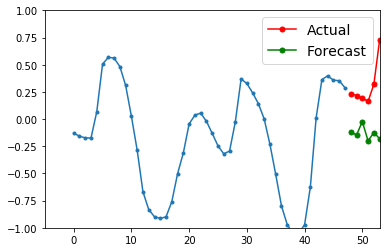

In [61]:
plot_multiple_distributed_forecasts(train_data,train_labels, model1.predict(train_data))

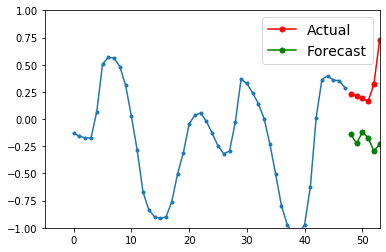

In [62]:
plot_multiple_distributed_forecasts(train_data,train_labels, model2.predict(train_data))

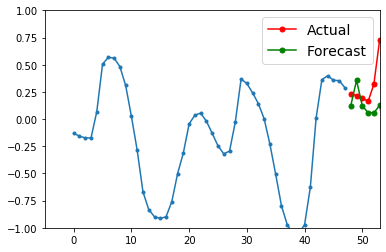

In [63]:
plot_multiple_distributed_forecasts(train_data,train_labels, model3.predict(train_data))